## Wind Energy Science paper Notebook

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import act
import xradar as xd
import numpy as np

from scipy.signal import convolve2d

In [2]:
ds = xr.open_mfdataset('/Users/rjackson/wfip3/data/*.3dvar*.nc')

In [92]:
ds["wind_dir"] = np.rad2deg(np.arctan2(-ds["u"], -ds["v"]))

In [2]:
ds_vad = xr.open_mfdataset('/Users/rjackson/wfip3/data/VAD_184_20240601_*.hpl', engine='hpl')
ds_vad

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [243]:
ds_stare = xr.open_dataset('/Users/rjackson/wfip3/data/nant.lidar.z01.a0.20240601.000021.fpt.nc')

In [244]:
ds_stare

<xarray.Dataset> Size: 32MB
Dimensions:                 (time: 3270, range_gate: 400)
Coordinates:
  * time                    (time) datetime64[ns] 26kB 2024-06-01T00:00:21.90...
  * range_gate              (range_gate) float64 3kB 0.0 1.0 2.0 ... 398.0 399.0
Data variables: (12/21)
    azimuth                 (time) float32 13kB ...
    elevation               (time) float32 13kB ...
    pitch                   (time) float32 13kB ...
    roll                    (time) float32 13kB ...
    radial_wind_speed       (time, range_gate) float32 5MB ...
    intensity               (time, range_gate) float32 5MB ...
    ...                      ...
    qc_roll                 (time) int32 13kB ...
    qc_radial_wind_speed    (time, range_gate) int32 5MB ...
    qc_intensity            (time, range_gate) int32 5MB ...
    qc_distance             (range_gate) int32 2kB ...
    qc_distance_overlapped  (range_gate) int32 2kB ...
    qc_SNR                  (time, range_gate) int32 5MB ...
Attributes: (12/21)
    Range gate length (m):  30.0
    Number of gates:        400.0
    Scan type:              Stare
    Pulses or ray:          10000.0
    System ID:              184
    Filename:               Stare_184_20240601_00
    ...                     ...
    datastream:             nant.lidar.z01.a0
    history:                Ran by sbx_user1051 at 2024-06-25T19:45:03.178315
    code_version:           b27838e70e14b69abc83993baca9d02615c43af3
    location_meaning:       Nantucket Site
    inputs:                 /tmp/tmpmpv0ajrw/wfip3/nant.lidar.z01.00/2024/06/...
    qualifier:              fpt

In [229]:
def get_velocity_variance(ds, window=(3, 3), field='mean_doppler_velocity'):
    """

    Gets the velocity variance over the prescribed window from the
    xarray dataset

    Parameters
    ----------
    ds: xarray Dataset
        The lidar dataset.
    window: (int, int) tuple
        The (range x time) window to perform the standard deviation on.
    field: str
        The mean doppler velocity field.
    """

    conv_kernel = 1 / (window[0] * window[1]) * np.ones(window)
    mean_vel = convolve2d(ds[field], conv_kernel, mode='same')
    variance = convolve2d((ds[field] - mean_vel) ** 2, conv_kernel, mode='same')
    ds['velocity_variance'] = (['time', 'range'], variance)
    return ds

In [230]:
ds_stare = get_velocity_variance(ds_stare, window=(30, 1), field='radial_wind_speed')

In [231]:
ds_stare['radial_wind_speed'].T.plot(vmin=-3, vmax=3, cmap='balance', y='range')

ValueError: y must be one of None, 'range_gate', 'time'. Received 'range' instead.

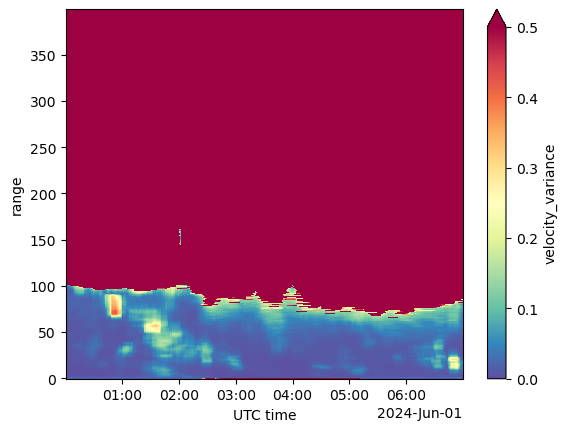

In [232]:
ds_stare['velocity_variance'].T.plot(
    vmin=0, vmax=0.5, cmap='Spectral_r', y='range')

In [7]:
vads = act.retrievals.compute_winds_from_ppi(ds_vad, radial_velocity_name='mean_doppler_velocity')

(0.0, 3000.0)

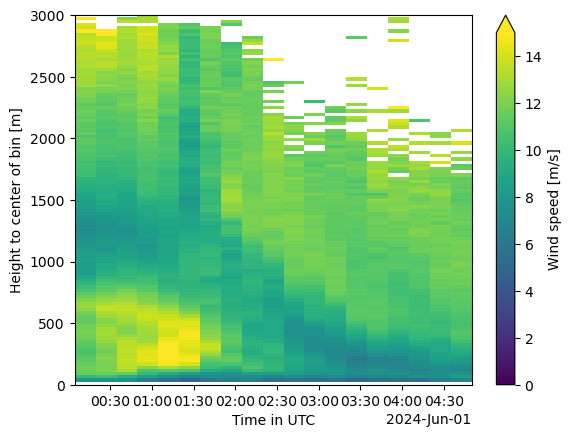

In [8]:
vads["wind_speed"].T.plot(vmin=0, vmax=15)
plt.ylim([0, 3000])

In [9]:
vads["wind_shear"] = vads["wind_speed"].diff(dim='height') / vads["height"].diff(dim='height') * 1e3

In [20]:
z = 150
wind_speed_bins = np.arange(0, 20, 1)
wind_dir_bins = np.arange(90, 270, 5)
wind_shear_bins = np.arange(-30, 30, 1)
wind_speed_hists = np.zeros((len(ds['y'].values), len(wind_speed_bins) - 1))
wind_shear_hists = np.zeros((len(ds['y'].values), len(wind_shear_bins) - 1))
wind_dir_hists = np.zeros((len(ds['y'].values), len(wind_dir_bins) - 1))
for i, y in enumerate(ds['y'].values):
    hist, bins = np.histogram(ds['wind_speed'].sel(y=y, z=z).values.flatten(), bins=wind_speed_bins)
    wind_speed_hists[i, :] = hist / np.sum(hist)
    hist, bins = np.histogram(ds['vert_shear'].sel(y=y, z=z).values.flatten(), bins=wind_shear_bins)
    wind_shear_hists[i, :] = hist / np.sum(hist)
    hist, bins = np.histogram(ds['wind_dir'].sel(y=y, z=z).values.flatten(), bins=wind_dir_bins)
    wind_dir_hists[i, :] = hist / np.sum(hist)

Text(0, 0.5, 'Wind speed [m/s]')

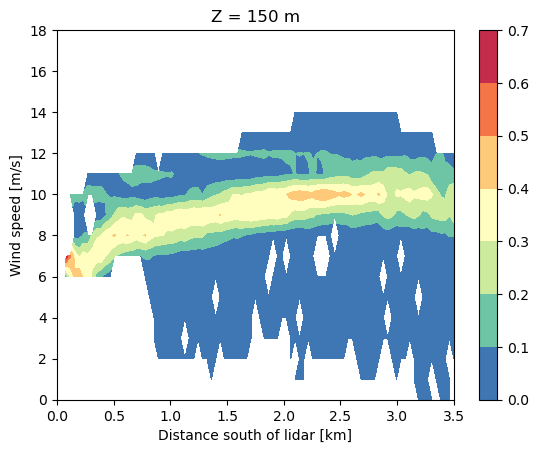

In [11]:
wind_speed_hists = np.where(wind_speed_hists > 0, wind_speed_hists, np.nan)
x, y = np.meshgrid(-ds['y'].values / 1e3, wind_speed_bins[:-1])
c = plt.contourf(x, y, wind_speed_hists.T, cmap='Spectral_r')
plt.colorbar(c)
plt.title('Z = %d m' % z)
plt.xlabel('Distance south of lidar [km]')
plt.ylabel('Wind speed [m/s]')

Text(0, 0.5, 'Wind speed [m/s]')

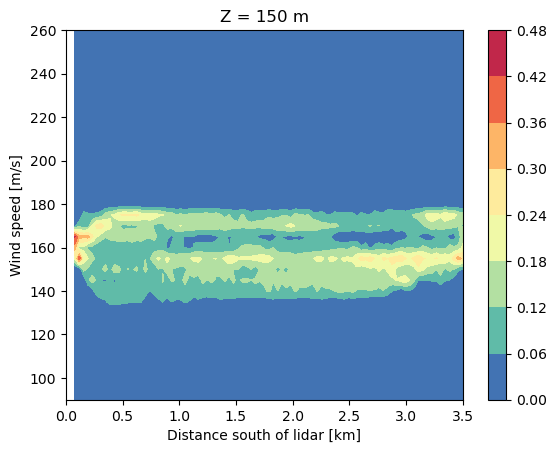

In [12]:
wind_speed_hists = np.where(wind_dir_hists > 0, wind_dir_hists, np.nan)
x, y = np.meshgrid(-ds['y'].values / 1e3, wind_dir_bins[:-1])
c = plt.contourf(x, y, wind_dir_hists.T, cmap='Spectral_r')
plt.colorbar(c)
plt.title('Z = %d m' % z)
plt.xlabel('Distance south of lidar [km]')
plt.ylabel('Wind speed [m/s]')

Text(0, 0.5, 'Vertical Wind shear [$m\\ s^{-1}\\ km^{-1}$]')

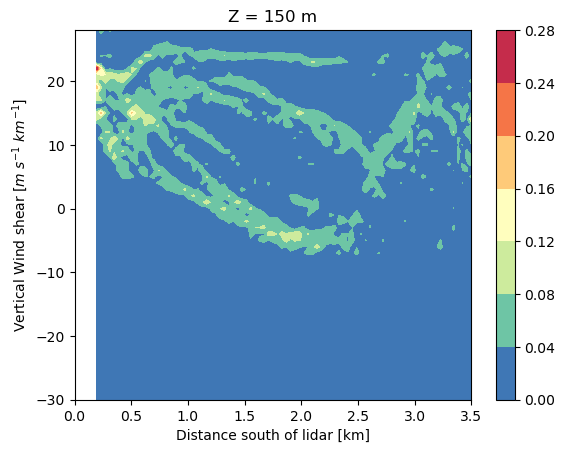

In [23]:
wind_speed_hists = np.where(wind_shear_hists > 0, wind_shear_hists, np.nan)
x, y = np.meshgrid(-ds['y'].values / 1e3, wind_shear_bins[:-1])
c = plt.contourf(x, y, wind_shear_hists.T, cmap='Spectral_r')
plt.colorbar(c)
plt.title('Z = %d m' % z)
plt.xlabel('Distance south of lidar [km]')
plt.ylabel('Vertical Wind shear [$m\ s^{-1}\ km^{-1}$]')

In [89]:
ds['wind_speed'] = np.sqrt(ds['u']**2 + ds['v']**2)

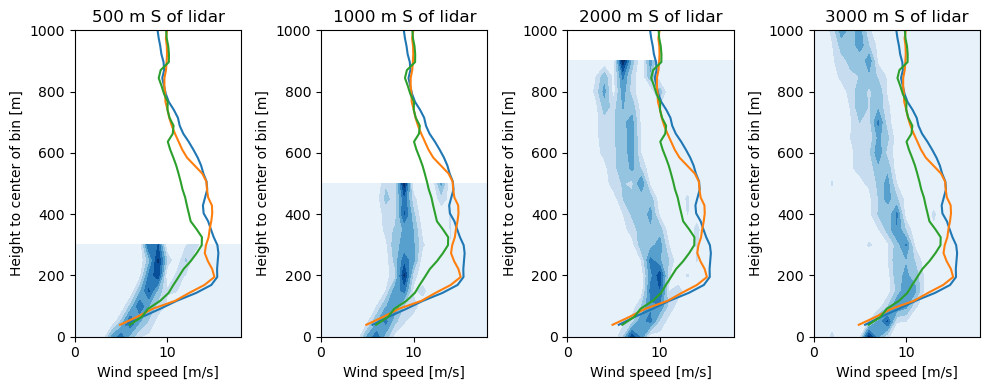

In [90]:
y = [-500, -1000, -2000, -3000]
fig, ax = plt.subplots(1, len(y), figsize=(10, 4))
for j, xi in enumerate(y):
    wind_speed_bins = np.arange(0, 20, 1)
    wind_dir_bins = np.arange(90, 270, 5)
    wind_shear_bins = np.arange(-30, 30, 1)
    wind_speed_hists = np.zeros((len(ds['z'].values), len(wind_speed_bins) - 1))
    wind_shear_hists = np.zeros((len(ds['z'].values), len(wind_shear_bins) - 1))
    wind_dir_hists = np.zeros((len(ds['z'].values), len(wind_dir_bins) - 1))
    for i, z in enumerate(ds['z'].values):
        hist, bins = np.histogram(ds['wind_speed'].sel(z=z, y=xi, method='nearest').values.flatten(), bins=wind_speed_bins)
        wind_speed_hists[i, :] = hist / np.sum(hist)
        hist, bins = np.histogram(ds['vert_shear'].sel(z=z, y=xi, method='nearest').values.flatten(), bins=wind_shear_bins)
        wind_shear_hists[i, :] = hist / np.sum(hist)
        hist, bins = np.histogram(ds['wind_dir'].sel(z=z, y=xi, method='nearest').values.flatten(), bins=wind_dir_bins)
        wind_dir_hists[i, :] = hist / np.sum(hist)
    
    x, y = np.meshgrid(wind_speed_bins[:-1], ds['z'].values)
    c = ax[j].contourf(x, y, wind_speed_hists, cmap='Blues', vmin=0, vmax=0.5)
    if j == len(y) - 1:
        bar = plt.colorbar(c, ax=ax[j], label='Norm. frequency')
    vads['wind_speed'].isel(time=4).plot(label='011212 UTC', y='height', ax=ax[j])
    vads['wind_speed'].isel(time=5).plot(label='012713 UTC', y='height', ax=ax[j])
    vads['wind_speed'].isel(time=6).plot(label='014423 UTC', y='height', ax=ax[j])
    ax[j].set_ylim([0, 1000])
    ax[j].set_title('%d m S of lidar' % (-xi))
fig.tight_layout()
fig.savefig('VAD_vs_volume_comparison.png')

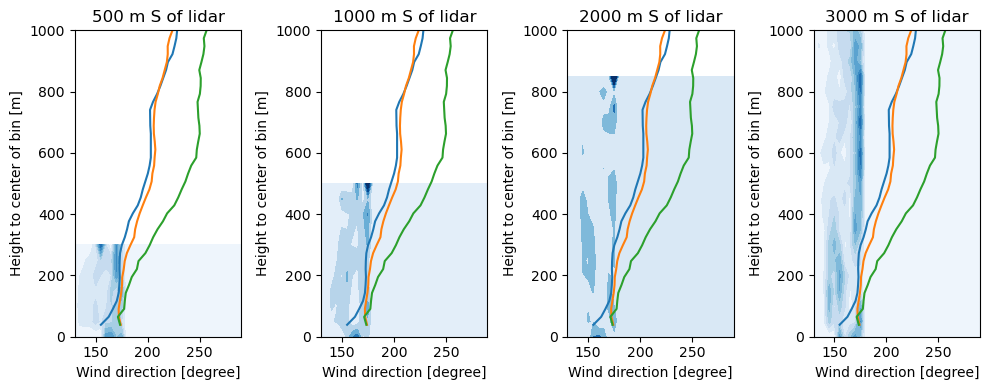

In [95]:
y = [-500, -1000, -2000, -3000]
fig, ax = plt.subplots(1, len(y), figsize=(10, 4))
for j, xi in enumerate(y):
    wind_speed_bins = np.arange(0, 20, 1)
    wind_dir_bins = np.arange(130, 300, 5)
    wind_shear_bins = np.arange(-30, 30, 1)
    wind_speed_hists = np.zeros((len(ds['z'].values), len(wind_speed_bins) - 1))
    wind_shear_hists = np.zeros((len(ds['z'].values), len(wind_shear_bins) - 1))
    wind_dir_hists = np.zeros((len(ds['z'].values), len(wind_dir_bins) - 1))
    for i, z in enumerate(ds['z'].values):
        hist, bins = np.histogram(ds['wind_speed'].sel(z=z, y=xi, method='nearest').values.flatten(), bins=wind_speed_bins)
        wind_speed_hists[i, :] = hist / np.sum(hist)
        hist, bins = np.histogram(ds['vert_shear'].sel(z=z, y=xi, method='nearest').values.flatten(), bins=wind_shear_bins)
        wind_shear_hists[i, :] = hist / np.sum(hist)
        hist, bins = np.histogram(ds['wind_dir'].sel(z=z, y=xi, method='nearest').values.flatten(), bins=wind_dir_bins)
        wind_dir_hists[i, :] = hist / np.sum(hist)
    
    x, y = np.meshgrid(wind_dir_bins[:-1], ds['z'].values)
    c = ax[j].contourf(x, y, wind_dir_hists, cmap='Blues', vmin=0, vmax=0.5)
    if j == len(y) - 1:
        bar = plt.colorbar(c, ax=ax[j], label='Norm. frequency')
    vads['wind_direction'].isel(time=4).plot(label='011212 UTC', y='height', ax=ax[j])
    vads['wind_direction'].isel(time=5).plot(label='012713 UTC', y='height', ax=ax[j])
    vads['wind_direction'].isel(time=6).plot(label='014423 UTC', y='height', ax=ax[j])
    ax[j].set_ylim([0, 1000])
    ax[j].set_title('%d m S of lidar' % (-xi))
fig.tight_layout()
fig.savefig('VAD_vs_volume_comparison_dir.png')

In [149]:
ds_radial_vel_one_sweeps = xr.open_mfdataset('/Users/rjackson/wfip3/data/User1_184_20240515_033001.hpl', engine='hpl')
ds_radial_vel_one_sweeps

<xarray.Dataset> Size: 620kB
Dimensions:                (time: 96, range: 400, sweep: 1)
Coordinates:
  * range                  (range) float64 3kB 15.0 45.0 ... 1.196e+04 1.198e+04
  * time                   (time) datetime64[ns] 768B 2024-05-15T03:30:06.639...
Dimensions without coordinates: sweep
Data variables: (12/17)
    intensity              (time, range) float32 154kB dask.array<chunksize=(96, 400), meta=np.ndarray>
    mean_doppler_velocity  (time, range) float32 154kB dask.array<chunksize=(96, 400), meta=np.ndarray>
    backscatter            (time, range) float32 154kB dask.array<chunksize=(96, 400), meta=np.ndarray>
    spectral_width         (time, range) float32 154kB dask.array<chunksize=(96, 400), meta=np.ndarray>
    pitch                  (time) float32 384B dask.array<chunksize=(96,), meta=np.ndarray>
    roll                   (time) float32 384B dask.array<chunksize=(96,), meta=np.ndarray>
    ...                     ...
    latitude               float32 4B ...
    longitude              float32 4B ...
    altitude               float32 4B ...
    sweep_start_ray_index  (sweep) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    sweep_end_ray_index    (sweep) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    antenna_transition     (time) float32 384B dask.array<chunksize=(96,), meta=np.ndarray>

In [287]:
ds_radial_vel_one_sweeps = xd.io.open_hpl_datatree('/Users/rjackson/wfip3/data/User1_184_20240601_002752.hpl', sweep=[0])
ds_radial_vel_one_sweeps

TypeError: only integer scalar arrays can be converted to a scalar index

In [151]:
dataset = get_velocity_variance(ds_radial_vel_one_sweeps, window=(10, 10))

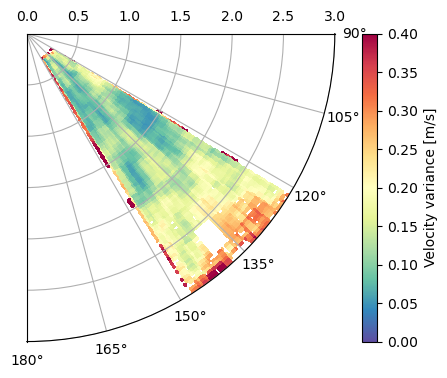

In [152]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection="polar"), figsize=(7, 4))
r, theta = np.meshgrid(dataset.range.values / 1e3, np.deg2rad(dataset["azimuth"].values), indexing='xy')
c = ax.pcolormesh(theta, r, dataset.velocity_variance.where(np.logical_and(
    dataset.intensity > 1.01, dataset.velocity_variance < 0.5)).values, vmin=0, vmax=0.4, cmap='Spectral_r')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetalim([np.pi/2, np.pi])
ax.set_rlim([0, 3])
plt.colorbar(c, ax=ax, label='Velocity variance [m/s]')

In [173]:
def get_velocity_variance_2d(ds, window=(3, 3), u_field='u', v_field='v'):
    """

    Gets the velocity variance over the prescribed window from the
    xarray dataset

    Parameters
    ----------
    ds: xarray Dataset
        The lidar dataset.
    window: (int, int) tuple
        The (range x time) window to perform the standard deviation on.
    field: str
        The mean doppler velocity field.
    """

    conv_kernel = 1 / (window[0] * window[1]) * np.ones(window)
    variance = np.zeros_like(ds[u_field].values)
    for i in range(len(ds['time'].values)):
        for j in range(len(ds['z'].values)):
            mean_vel = convolve2d(ds[u_field].values[i, j], conv_kernel, mode='same')
            variance[i, j] = convolve2d((ds[u_field].values[i, j] - mean_vel) ** 2, conv_kernel, mode='same')
    
    ds['u_variance'] = (['time', 'z', 'y', 'x'], variance)
    variance = np.zeros_like(ds[u_field].values)
    for i in range(len(ds['time'].values)):
        for j in range(len(ds['z'].values)):
            mean_vel = convolve2d(ds[v_field].values[i, j], conv_kernel, mode='same')
            variance[i, j] = convolve2d((ds[v_field].values[i, j] - mean_vel) ** 2, conv_kernel, mode='same')
    ds['v_variance'] = (['time', 'z', 'y', 'x'], variance)
    return ds

In [176]:
ds = get_velocity_variance_2d(ds, window=(3, 3))
ds

<xarray.Dataset> Size: 167MB
Dimensions:           (time: 6, z: 21, y: 91, x: 81, nradar: 1)
Coordinates:
  * time              (time) datetime64[ns] 48B 2024-06-01T01:18:03.009996 .....
  * z                 (z) float64 168B 0.0 50.0 100.0 ... 900.0 950.0 1e+03
    lat               (y, x) float64 59kB dask.array<chunksize=(91, 81), meta=np.ndarray>
    lon               (y, x) float64 59kB dask.array<chunksize=(91, 81), meta=np.ndarray>
  * y                 (y) float64 728B -3.5e+03 -3.461e+03 ... -38.89 0.0
  * x                 (x) float64 648B -2e+03 -1.95e+03 ... 1.95e+03 2e+03
Dimensions without coordinates: nradar
Data variables: (12/30)
    beta              (time, z, y, x) float64 7MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    radial_velocity   (time, z, y, x) float64 7MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    reflectivity      (time, z, y, x) float64 7MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    intensity         (time, z, y, x) float64 7MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    spectral_width    (time, z, y, x) float64 7MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    ROI               (time, z, y, x) float32 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    ...                ...
    wind_speed        (time, z, y, x) float64 7MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    vert_shear        (time, z, y, x) float64 7MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    wind_dir          (time, z, y, x) float64 7MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    u_variance        (time, z, y, x) float64 7MB nan nan nan ... nan nan nan
    v_variance        (time, z, y, x) float64 7MB nan nan nan ... nan nan nan
    tke_2d            (time, z, y, x) float64 7MB nan nan nan ... nan nan nan
Attributes:
    nradar:           1
    radar_name:       
    Conventions:      CF-1.7
    version:          CF-Radial-1.4
    volume_number:    0
    platform_type:    fixed
    instrument_type:  radar
    primary_axis:     axis_z
    first_grid_name:  beta
    units:            m
    long_name:        Point altitude

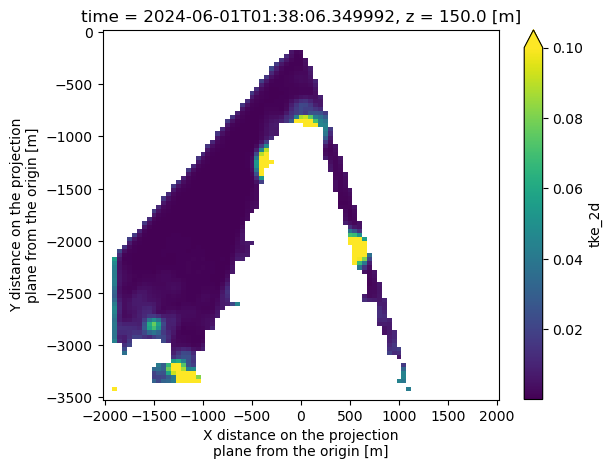

In [269]:
ds["tke_2d"] = 0.5 * (ds["u_variance"] + ds["v_variance"])
ds["tke_2d"].where(ds["tke_2d"] < 1).isel(time=4, z=3).plot(vmax=0.1)

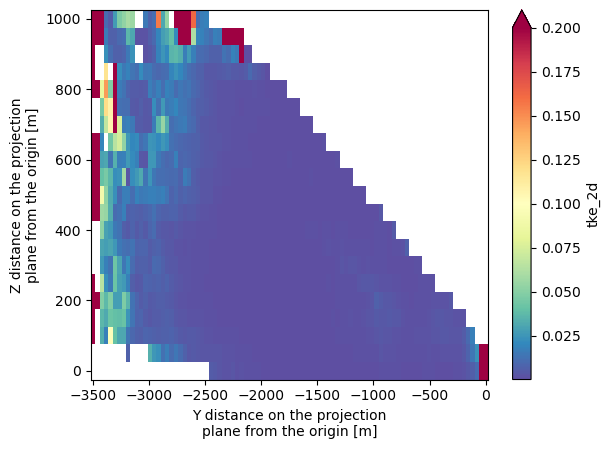

In [282]:
ds["tke_2d"].where(ds["tke_2d"] < 1).median(dim=['time', 'x']).plot(vmax=0.2, cmap='Spectral_r')

(0.0, 1000.0)

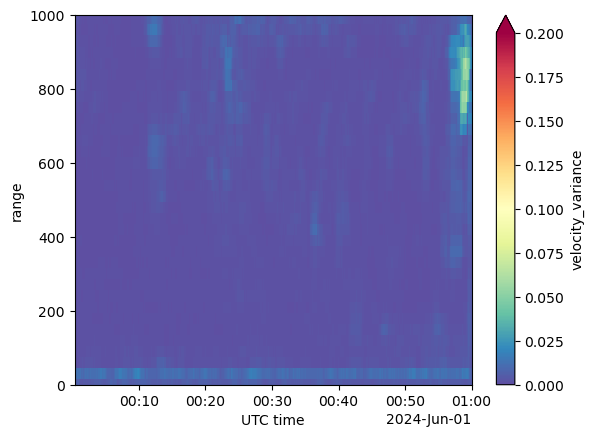

In [278]:
ds_stare = get_velocity_variance(ds_stare, window=(60, 1), field='radial_wind_speed')
(0.5*ds_stare['velocity_variance']).T.plot(
    vmin=0, vmax=0.2, cmap='Spectral_r', y='range')
plt.ylim([0, 1000])

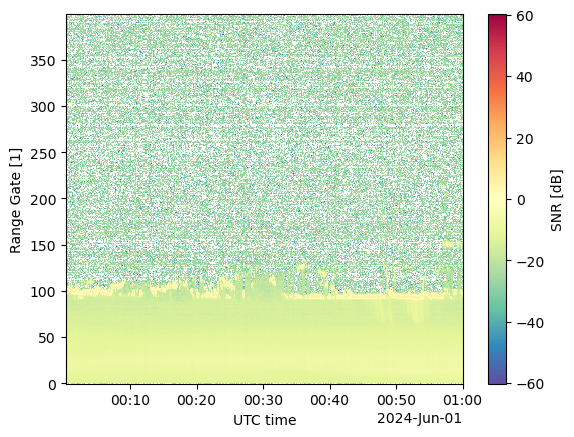

In [261]:
ds_stare['SNR'].T.plot(
     cmap='Spectral_r')

In [260]:
ds_stare['range'] = ds_stare['range'] * 30.